# Выбор локации для скважины

Добывающая компания «ГлавРосГосНефть» планирует разрабатывать новые регионы месторождений. Для этого ей требуется собственная модель машинного обучения, которая позволит отбирать наилучшие по выработке месторождения нефти на основании качества проб и их оценки по трем параметрам.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройм модель машинного обучения, которая выявит закономерности и поможет определить регион, где добыча принесёт наибольшую прибыль. Возможную прибыль и риски убытков будем оценивать техникой *Bootstrap*. 

Шаги для выбора локации:

- В каждом регионе ищем месторождения, для каждого определяем значения признаков;
- Строим модель и оцениваем объём запасов;
- Выбираем месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Определяем прибыль и риски

Значения столбцов датасета:
 - id — уникальный идентификатор скважины;
 - f0, f1, f2 — признаки месторождени);
 - product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, roc_auc_score, precision_recall_curve

pd.options.mode.chained_assignment = None

### Сохраним ключевые метрики в переменных: 
- `sample_size` - объем выборки для bootstrap
- `cost_per_region` - бюджет на разработку 200 скважин в регионе
- `sample_ml` - объем выборки для модели машинного обучения
- `price` - выручка за 1 тысячу баррелей
- `q` - квантиль

In [2]:
cost_per_region = 10_000_000_000
sample_size = 500
price = 450000
sample_ml = 200
q = 0.95

### Загрузка и обзор датасета

#### Загрузка датасетов и подготовка списка:

In [3]:
data_0 = pd.read_csv('geo_data_0.csv')
data_1 = pd.read_csv('geo_data_1.csv')
data_2 = pd.read_csv('geo_data_2.csv')

datasets = []
datasets.append(data_0)
datasets.append(data_1)
datasets.append(data_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB


None

Явные дубликаты датасета : 0
[[<AxesSubplot:title={'center':'product'}>]]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB


None

Явные дубликаты датасета : 0
[[<AxesSubplot:title={'center':'product'}>]]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB


None

Явные дубликаты датасета : 0
[[<AxesSubplot:title={'center':'product'}>]]



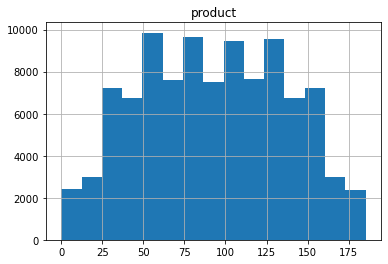

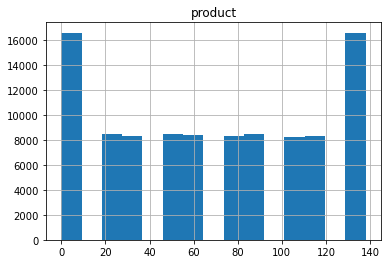

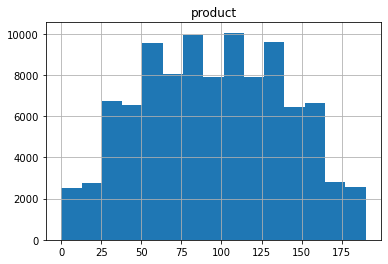

In [4]:
for i in datasets:
    display(i.info(memory_usage='deep'))
    print(f'Явные дубликаты датасета : {i.duplicated().sum()}')
    print(i.hist('product', bins=15));
    print()

#### Подготовка функции для обзора целевого значения:

In [5]:
def review(df, col): 
    '''Функция для обзора распределения данных методом describe.
    В качестве аргументов принимает df=датафрейм, col=столбец для обзора, pregion=регион разработки'''
    pl = df.boxplot('product', vert = False, figsize=(20, 5));
    
    desc = df[col].describe()
    print(f'Медиана:', round(df[col].median(), 2))
    print(f'Межквартильный размах находятся в диапазоне между значениями {round(desc[4], 2)} и {round(desc[6], 2)}')
    poltora_q1 = desc[4] - 1.5*(desc[6] - desc[4])
    if poltora_q1 < 0:
        print(f'Нормальный диапазон значений региона: c {round(desc[3], 3)} до {round(desc[6] + 1.5*(desc[6] - desc[4]), 3)}' )
    else:
        print(f'Нормальный диапазон значений: \
c {round(desc[4] - 1.5*(desc[6] - desc[4]), 3)} до {round(desc[6] + 1.5*(desc[6] - desc[4]), 3)}' )

#### Обзор датасетов и целевого значени

Медиана: 91.85
Межквартильный размах находятся в диапазоне между значениями 56.5 и 128.56
Нормальный диапазон значений региона: c 0.0 до 236.664


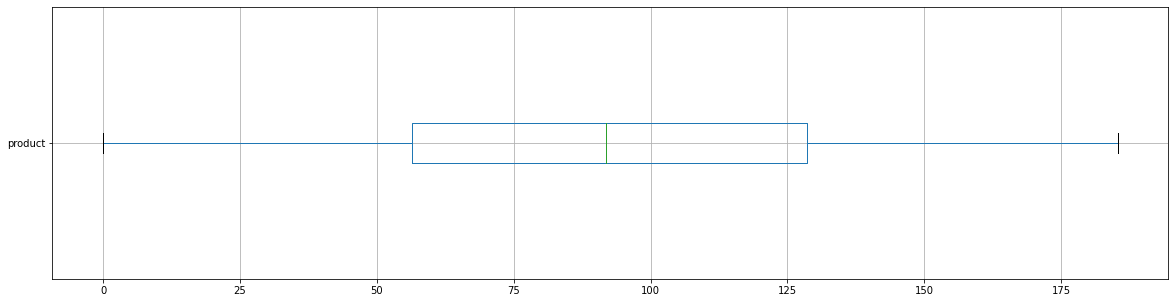

In [6]:
review(data_0, 'product')

Медиана: 57.09
Межквартильный размах находятся в диапазоне между значениями 26.95 и 107.81
Нормальный диапазон значений региона: c 0.0 до 229.103


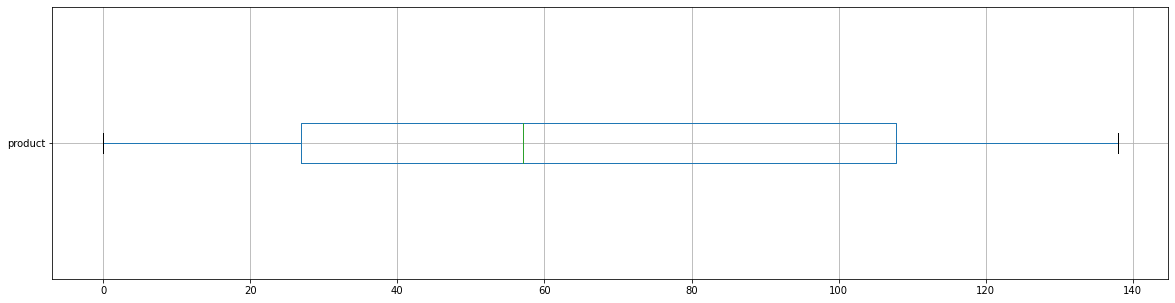

In [7]:
review(data_1, 'product')

Медиана: 94.93
Межквартильный размах находятся в диапазоне между значениями 59.45 и 130.6
Нормальный диапазон значений региона: c 0.0 до 237.312


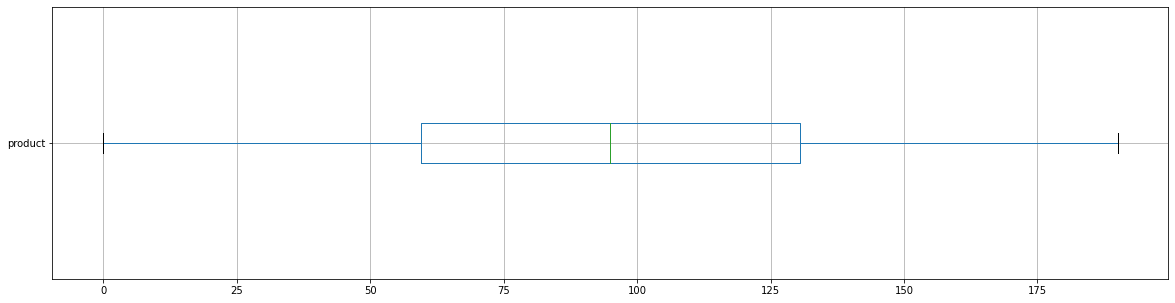

In [8]:
review(data_2, 'product')

**Вывод:** 
1. Предоставленные заказчиком датасеты подготовленные: типы данных соответствуют значениям, пропуски и дубликаты отсутствуют. 
2. Каждый датасет имеет данные на 100000 скважин. Категориальные признаки отсутствуют - все данные количественные, dummy-classifier не требуется. 
3. Распределения 1 и 3 региона распределены нормально, со схожими средними значениями в районе 93 тыс.баррелей на скважину. Распределение региона 2 неопределенное, имеет низкое среднее значение и множество "пустых" скважин. 

## Обучение и проверка модели

Обучим модель линейной регрессии отдельно для каждого региона для определения среднего квадратичной ошибки, коэффициента детерминации, определим средний запас сырья по регионам 1 2 3. Деление на выборки производим сразу в функции, а для последующей оценки прибыли таргеты, предсказания на валидационной выборке, средние вносим в списки `target_list`, `prediction_list` и `mean_list`. Для дальнейшего расчета прибыли переведем каждом блоке предсказания в Series, а у целевых показатели валидационной выборки сбросим индексы.

In [9]:
prediction_list = []
target_list = []
mean_list = []
def rmse_review(df_list):
    for i in df_list:        
        features = i.drop(['id','product'], axis=1)
        target= i['product']
        features_train, features_valid, target_train, target_valid = train_test_split(
            features, target, test_size=0.25, random_state=433)
    
        model = LinearRegression()
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        
        target_valid = target_valid.reset_index(drop=True)
        predictions = pd.Series(predictions)
        mean = predictions.mean()
        
        prediction_list.append(predictions)
        target_list.append(target_valid)
        mean_list.append(mean)
        
        print('Средний запас сырья по месторождениям региона:', mean)
        print('RMSE региона:', mean_squared_error(target_valid, predictions)**0.5)
        print()

In [10]:
rmse_review(datasets)

Средний запас сырья по месторождениям региона: 92.31139550425699
RMSE региона: 37.61805085279286

Средний запас сырья по месторождениям региона: 68.62142355900797
RMSE региона: 0.8888533415096879

Средний запас сырья по месторождениям региона: 94.98729323778443
RMSE региона: 40.07661209455226



**Вывод:** 
1. Регионы 0 и 2 содержат большой средний запас сырья 94.98 и 92 тыс.баррелей соответственно с RMSE 37.6 и 40.1 соответственно
2. Самый низкий средний запас на 1 скважину - в регионе 2: 68.6 тыс.баррелей, ошибка RMSE крайне низкая 0.9. На мой взгляд данные по этому региону содержат ошибку.

## Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки 1 новой скважины и сравним его со средним запасом сырья в каждом регионе:

In [11]:
min_vol = cost_per_region / (price * sample_ml)
print(f'Минимальный объем выработки сырья для достижения безубыточности составляет {round(min_vol, 2)} тысяч баррелей.')

Минимальный объем выработки сырья для достижения безубыточности составляет 111.11 тысяч баррелей.


In [12]:
for i in mean_list:
    print(f'Расчетная прибыль для региона {mean_list.index(i)} по среднему значению: {i * price * sample_ml - cost_per_region}')

Расчетная прибыль для региона 0 по среднему значению: -1691974404.61687
Расчетная прибыль для региона 1 по среднему значению: -3824071879.6892834
Расчетная прибыль для региона 2 по среднему значению: -1451143608.5994024


In [13]:
for i in prediction_list:
    print(f'Вероятность убытков в регионе при средней добыче со скважины: {len(i[i < min_vol]) / len(i)}')

Вероятность убытков в регионе при средней добыче со скважины: 0.79092
Вероятность убытков в регионе при средней добыче со скважины: 0.82232
Вероятность убытков в регионе при средней добыче со скважины: 0.79024


**Вывод:** Средний объем сырья 200 скважин каждого региона не позволяет достигнуть точки безубыточности. Для безубыточной разработки требуется выбирать наиболее прибыльные скважины - у которых выработка сырья будет в среднем более 111.11 тыс. баррелей. Риск получения убытков при выборе скважин наугад высокий и составялет 79-82% в зависимости от региона.

## Напишитем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

In [14]:
def profit(targets, predictions, count, price, costs):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = targets[predictions_sorted.index][:count]
    return price * selected.sum() - costs

## Расчёт прибыли и рисков 

Напишем функцию расчета средней выручки, выведем для нее доверительный и риски:

In [15]:
def profit_risks(target, prediction, percent, region):
    state = np.random.RandomState(12345)
    values_profit = []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        pred_subsample = prediction[target_subsample.index] 
        target_subsample = target_subsample.reset_index(drop=True)
        pred_subsample = pred_subsample.reset_index(drop=True)
        values_profit.append(profit(target_subsample, pred_subsample, sample_ml, price, cost_per_region))
    
    values_profit = pd.Series(values_profit)
    mean = values_profit.mean()
    lower = values_profit.quantile((1-percent)/2)
    upper = values_profit.quantile(percent + (1-percent)/2)

    print(f'Средняя выручка региона {region}: {round(mean,2)}')
    print(f'95%-й доверительный интервал для средней прибыли региона {region}: с {lower:.2e} до {upper:.2e}')
    print(f'Вероятность убытков в регионе {region}: {round((values_profit < 0).mean() * 100, 2)}%')
    print()

In [16]:
profit_risks(target_list[0], prediction_list[0], q, 0)
profit_risks(target_list[1], prediction_list[1], q, 1)
profit_risks(target_list[2], prediction_list[2], q, 2)

Средняя выручка региона 0: 370381571.6
95%-й доверительный интервал для средней прибыли региона 0: с -1.58e+08 до 9.10e+08
Вероятность убытков в регионе 0: 7.6%

Средняя выручка региона 1: 406888515.45
95%-й доверительный интервал для средней прибыли региона 1: с 9.62e+06 до 7.92e+08
Вероятность убытков в регионе 1: 2.2%

Средняя выручка региона 2: 376901462.71
95%-й доверительный интервал для средней прибыли региона 2: с -1.35e+08 до 8.70e+08
Вероятность убытков в регионе 2: 7.8%



## Выводы:


Регион 1 - самый благоприятный для выполнения изысканий и бурения скважин. Риск получения убытков составляет 2.2% при 95% -м доверительном интервале 9.62e+06 - 7.92e+08
Средняя выручка региона 1: 406 млн.руб.

Региона 0 и 2 имеют слишком высокий риск убытков: 7.6% и 7.8% соответственно для вложения средств в разработку. При этом средняя ожидаемая прибыль в них соизмерима с регионом 1 (~370 млн.руб.) при более, чем в 3 раза большем риске.